In [1]:
import torch
from transformers import MT5ForConditionalGeneration, MT5Config, MT5EncoderModel, MT5Tokenizer, Trainer, TrainingArguments
from progeny_tokenizer import TAPETokenizer
import numpy as np
import math
import random
import scipy
import time
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, Dataset, BatchSampler
import typing
from pathlib import Path
import argparse
from collections import OrderedDict
import pickle
import pathlib

import matplotlib.pyplot as plt

# Analyze FoldX ddG values of gen 10K

In [2]:
from tape.metrics import spearmanr

In [3]:
# results_tsv_name = "/export/home/experiments/prot5_alvin/utils/congen_results/unique250K_small_clspool_waeDeterencStart84kstep512dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-070-congen_seqs260000_top10Klatentheadfiltered/results_full.tsv"
# ddG_df = pd.read_table(results_tsv_name)

In [4]:
results_tsv_dir = "foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered"
# results_tsv_dir = "/export/home/experiments/prot5_alvin/utils/congen_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-159-congen_seqs260000_top10Klatentheadfiltered"

results_tsv_dir_path = pathlib.Path(results_tsv_dir)

results_tsv_files = list(results_tsv_dir_path.glob('results_batch*to*.tsv'))
print("results_tsv_files: ", results_tsv_files)
results_tsv_df_full = None
print("Merging result tsv files")
for tsv_ind, results_tsv_file in enumerate(results_tsv_files):
    print("tsv_ind: ", tsv_ind) 
    print("results_tsv_file: ", results_tsv_file)
    if tsv_ind == 0:
        results_tsv_df_full = pd.read_table(results_tsv_file)
    else:
        results_tsv_df = pd.read_table(results_tsv_file)
        results_tsv_df_full = results_tsv_df_full.append(results_tsv_df, ignore_index=True)

results_tsv_files:  [PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/results_batch11_2750to2999.tsv'), PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/results_batch8_2000to2249.tsv'), PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/results_batch6_1500to1749.tsv'), PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/results_batch1_250to499.tsv'), PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/results_batch0_0to249.tsv'), PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/results_batch10_2500to2749.tsv'), PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/results_batch2_500to749.tsv'), PosixPath('foldx_sim_results/top12500input1Kiter_temp01_trustr18-mcmc_seqs_top10Kdiscfiltered/re

In [5]:
ddG_df = results_tsv_df_full

In [6]:
use_only_topK = 1000 

In [7]:
ddG_df = ddG_df.sort_values(by='disc_pred', ascending=True)

ddG_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,MT_edit_dist_vs_WT,accepted,ddG
1000,2.795303,SDIEEQAKIFLDKFNNEREDLFYQSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.66565
1001,2.795731,SSIEEQAKTFLAKFAHEAEQLKYQSELALWNFNTNITEENVTNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.52283
1002,2.797057,SDIEEQAKIFLDKFNNEREDLFYMSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-4.67085
1003,2.797315,SSLEEQARIFLDKFNHESEDLFYQSALALMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.29315
1004,2.798953,SSIEEQAKTFLEKFNHEAHDIFYLMELESATYNTNITEENVQNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.63749
...,...,...,...,...,...,...,...,...,...
245,2.867813,SGIEEQAKTFLDEFNHEAEMLFYKSKLASWFYNTNITEENKWNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-2.75965
246,2.867816,SDIEEQANTFLDKFFHQAEYLFMGSKLALWNYNTNITEENLQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.23651
247,2.867826,RTIELYALWFLDKFNHEAEMLILQASLASWMYNTNITEENVQNMEN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,17,1,-5.54598
248,2.867830,SYIEEFAKLFLDKFWHEAEDYFYQFSMASWQYNTNITEENVHIMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-6.92227


In [8]:
if use_only_topK is not None:
    ddG_df = ddG_df.iloc[:use_only_topK]
ddG_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,MT_edit_dist_vs_WT,accepted,ddG
1000,2.795303,SDIEEQAKIFLDKFNNEREDLFYQSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.66565
1001,2.795731,SSIEEQAKTFLAKFAHEAEQLKYQSELALWNFNTNITEENVTNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.52283
1002,2.797057,SDIEEQAKIFLDKFNNEREDLFYMSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-4.67085
1003,2.797315,SSLEEQARIFLDKFNHESEDLFYQSALALMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.29315
1004,2.798953,SSIEEQAKTFLEKFNHEAHDIFYLMELESATYNTNITEENVQNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.63749
...,...,...,...,...,...,...,...,...,...
2995,2.846362,SDIEESAKTFLDSFNHEALDLFYYSQLASWFYNTNITEENGVNMFN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.59897
2996,2.846366,SSIEEQAKTFLLKFNIELEDLAYQSSLALSNYNTNITEENVDNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-2.39665
2997,2.846371,VQLEQQAKTFLDKFNHEATDLFYQFSLALWNYNTNITEENRHRMGN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-4.77876
2998,2.846387,STYEEQAKTFLWKFNFEANDLFFQSHLASWFYNTNITEENQQNMNA...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.04095


In [9]:
disc_pred_list = ddG_df['disc_pred']
ddG_list = ddG_df['ddG']

In [10]:
disc_ddG_cor = spearmanr(disc_pred_list, ddG_list)

In [11]:
disc_ddG_cor

0.004542965019976361

In [12]:
# latent_head_pred_list = ddG_df['latent_head_pred']
# ddG_list = ddG_df['ddG']
# latent_head_ddG_cor = spearmanr(latent_head_pred_list, ddG_list)
# print("latent_head_ddG_cor: ", latent_head_ddG_cor)

In [13]:
# Disc-predicted most stable ones first
# ddG_df = ddG_df.sort_values(by='latent_head_pred', ascending=True)
ddG_df = ddG_df.sort_values(by='disc_pred', ascending=True)

In [14]:
ddG_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,MT_edit_dist_vs_WT,accepted,ddG
1000,2.795303,SDIEEQAKIFLDKFNNEREDLFYQSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.66565
1001,2.795731,SSIEEQAKTFLAKFAHEAEQLKYQSELALWNFNTNITEENVTNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.52283
1002,2.797057,SDIEEQAKIFLDKFNNEREDLFYMSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-4.67085
1003,2.797315,SSLEEQARIFLDKFNHESEDLFYQSALALMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.29315
1004,2.798953,SSIEEQAKTFLEKFNHEAHDIFYLMELESATYNTNITEENVQNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.63749
...,...,...,...,...,...,...,...,...,...
2995,2.846362,SDIEESAKTFLDSFNHEALDLFYYSQLASWFYNTNITEENGVNMFN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.59897
2996,2.846366,SSIEEQAKTFLLKFNIELEDLAYQSSLALSNYNTNITEENVDNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-2.39665
2997,2.846371,VQLEQQAKTFLDKFNHEATDLFYQFSLALWNYNTNITEENRHRMGN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-4.77876
2998,2.846387,STYEEQAKTFLWKFNFEANDLFFQSHLASWFYNTNITEENQQNMNA...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.04095


In [15]:
top_half_stable_df = ddG_df[:len(ddG_df)//2]

In [16]:
top_half_stable_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,MT_edit_dist_vs_WT,accepted,ddG
1000,2.795303,SDIEEQAKIFLDKFNNEREDLFYQSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.66565
1001,2.795731,SSIEEQAKTFLAKFAHEAEQLKYQSELALWNFNTNITEENVTNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.52283
1002,2.797057,SDIEEQAKIFLDKFNNEREDLFYMSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-4.67085
1003,2.797315,SSLEEQARIFLDKFNHESEDLFYQSALALMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.29315
1004,2.798953,SSIEEQAKTFLEKFNHEAHDIFYLMELESATYNTNITEENVQNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.63749
...,...,...,...,...,...,...,...,...,...
995,2.835243,LYAEEAAKKFLDKFEHEAEDLYYQSSLFRWFYNTNITEENVFRWNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-2.41769
996,2.835305,SDAEEQAKHFLDNFNHEAEWLYYMSRLASWNFNTNITEENVQNMNG...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-6.71476
997,2.835321,VKVEEQAKIFLWKFNHEIRDLLRQSSLAKWDYNTNITEENVLNMNK...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,20,0,-5.45229
998,2.835362,ITIQEQAEYFLDKFIHWAEDLFSQASMASWFYNTNITEENVQRMNQ...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.33775


In [17]:
gen_train_data = 'data/gen_train_data/top_half_ddG/train_ddG.pkl'

In [18]:
gen_train_df = pd.read_pickle(gen_train_data)

In [19]:
gen_train_ddG_list = gen_train_df['ddG']

In [20]:
len(ddG_list)

1000

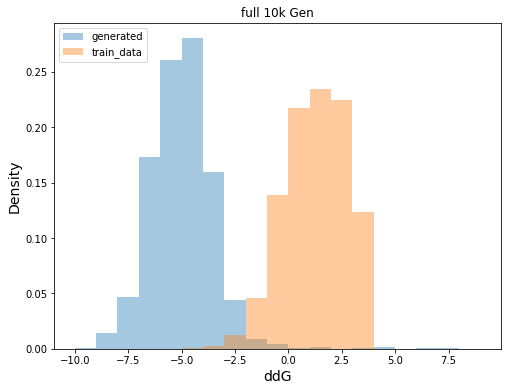

In [21]:
plt.figure(figsize=(8,6))
plt.hist(ddG_list, density=True, label='generated', bins=[i for i in range(-10, 10)], alpha=0.4)

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

In [22]:
len(top_half_stable_df['ddG'])

500

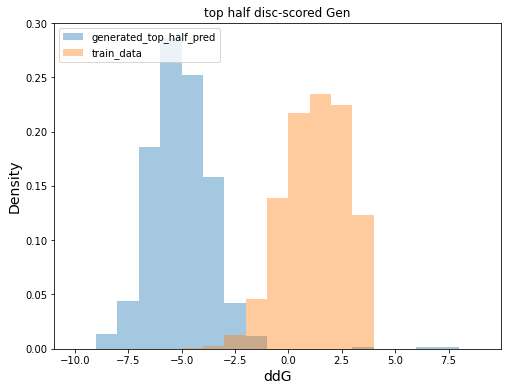

In [23]:
plt.figure(figsize=(8,6))
plt.hist(top_half_stable_df['ddG'], density=True, label='generated_top_half_pred', bins=[i for i in range(-10, 10)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("top half disc-scored Gen")
plt.legend(loc='upper left')

In [24]:
np.max(top_half_stable_df['ddG'])

7.50643

In [25]:
np.min(top_half_stable_df['ddG'])

-8.65199

In [26]:
np.mean(top_half_stable_df['ddG'])

-5.00503436

In [27]:
np.median(top_half_stable_df['ddG'])

-5.130245

In [28]:
np.max(gen_train_ddG_list)

3.5751

In [29]:
np.min(gen_train_ddG_list)

-6.59818

In [30]:
np.mean(gen_train_ddG_list)

1.26221709496

In [31]:
np.median(gen_train_ddG_list)

1.3439199999999998

## plot top 100, 1k and 10k distribution

In [32]:
rank_by_col = 'disc_pred'
# rank_by_col = 'latent_head_pred'

In [33]:
ddG_df = ddG_df.sort_values(by=rank_by_col, ascending=True)
disc_pred_list = ddG_df[rank_by_col]

ddG_list = ddG_df['ddG']

topk:  1000
topk_disc_ddG_cor:  0.004542965019976361
topk:  100
topk_disc_ddG_cor:  -0.013669407949080272


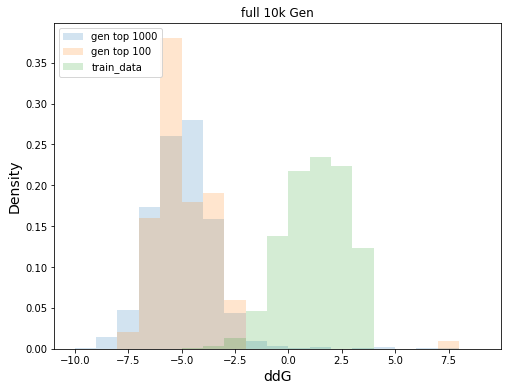

In [34]:
topk_hist_list = [ 1000, 100]
# topk_hist_list = [10000, 1000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)



plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

topk:  1000
topk_disc_ddG_cor:  0.004542965019976361
topk:  100
topk_disc_ddG_cor:  -0.013669407949080272


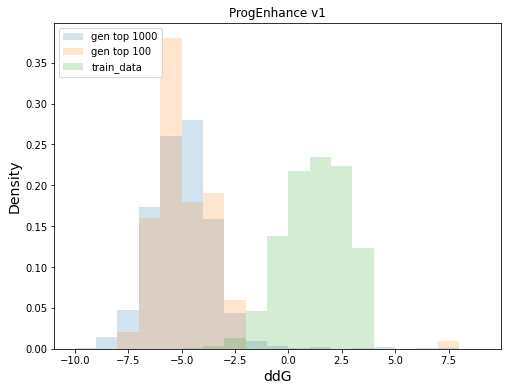

In [35]:
topk_hist_list = [1000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)


plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("ProgEnhance v1")
plt.legend(loc='upper left')

top 10, 100, 1000 by disc ranking

In [36]:
ddG_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,MT_edit_dist_vs_WT,accepted,ddG
1000,2.795303,SDIEEQAKIFLDKFNNEREDLFYQSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.66565
1001,2.795731,SSIEEQAKTFLAKFAHEAEQLKYQSELALWNFNTNITEENVTNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.52283
1002,2.797057,SDIEEQAKIFLDKFNNEREDLFYMSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-4.67085
1003,2.797315,SSLEEQARIFLDKFNHESEDLFYQSALALMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.29315
1004,2.798953,SSIEEQAKTFLEKFNHEAHDIFYLMELESATYNTNITEENVQNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.63749
...,...,...,...,...,...,...,...,...,...
2995,2.846362,SDIEESAKTFLDSFNHEALDLFYYSQLASWFYNTNITEENGVNMFN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.59897
2996,2.846366,SSIEEQAKTFLLKFNIELEDLAYQSSLALSNYNTNITEENVDNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-2.39665
2997,2.846371,VQLEQQAKTFLDKFNHEATDLFYQFSLALWNYNTNITEENRHRMGN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-4.77876
2998,2.846387,STYEEQAKTFLWKFNFEANDLFFQSHLASWFYNTNITEENQQNMNA...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.04095


In [37]:
topK_list = [10, 100, 1000]

In [38]:
topK_df = ddG_df[:10]
topK_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,MT_edit_dist_vs_WT,accepted,ddG
1000,2.795303,SDIEEQAKIFLDKFNNEREDLFYQSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.66565
1001,2.795731,SSIEEQAKTFLAKFAHEAEQLKYQSELALWNFNTNITEENVTNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.52283
1002,2.797057,SDIEEQAKIFLDKFNNEREDLFYMSKLASWRYNTNITEENVQNMNI...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-4.67085
1003,2.797315,SSLEEQARIFLDKFNHESEDLFYQSALALMNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.29315
1004,2.798953,SSIEEQAKTFLEKFNHEAHDIFYLMELESATYNTNITEENVQNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.63749
1005,2.799997,SSIEEQAKIFIDYFYHDAEDLFWQSALASWNYNTNITEENFSRMET...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-5.99236
1006,2.800226,SSIEEQTKTFLDKFNHLARLLFYQFSLASWNYNTNITEENYQFMYG...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-5.24705
1007,2.800896,SSIEERAKTFLDKFNHEAYFLFYQSSLALMNYNTNITEENEFNMNY...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.14299
1008,2.800990,SDYEETAKTFLNKFNFEAEELFYVSGLAEWMYNTNITEENFYNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,19,0,-3.56031
1009,2.801660,AGWEYIAYYFLWKFNHEATDLFYQSLLAWWIYNTNITEENVQNMNL...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,18,1,-3.83683


In [39]:
train_75pct =  np.percentile(gen_train_ddG_list, 25)

In [40]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    
    PCI_75pct = np.sum(topK_df['ddG'] < train_75pct) / len(topK_df['ddG'])
    print("PCI_75pct: ", PCI_75pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


PCI_75pct = np.sum(gen_train_ddG_list < train_75pct) / len(gen_train_ddG_list)
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -3.14299
min:  -5.99236
mean:  -4.456950999999999
median:  -4.25384
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  7.50643
min:  -7.36323
mean:  -4.839703199999999
median:  -5.216435
PCI_75pct:  0.99
PCI_WT:  0.99
____________________
top K:  1000
max:  9.13909
min:  -9.94838
mean:  -4.939772956999999
median:  -4.991085
PCI_75pct:  0.991
PCI_WT:  0.991
____________________
top half:  500
max:  7.50643
min:  -8.65199
mean:  -5.00503436
median:  -5.130245
PCI_75pct:  0.994
PCI_WT:  0.994
____________________
train dataset:  125000
max:  3.5751
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
PCI_75pct:  0.25
PCI_WT:  0.200864
____________________


In [41]:
topK_list = [10, 100, 1000]
percentile_list = [100, 95, 90, 85, 80, 75]

In [42]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -3.14299
min:  -5.99236
mean:  -4.456950999999999
median:  -4.25384
PCI_100pct:  0.0
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  7.50643
min:  -7.36323
mean:  -4.839703199999999
median:  -5.216435
PCI_100pct:  0.09
PCI_95pct:  0.99
PCI_90pct:  0.99
PCI_85pct:  0.99
PCI_80pct:  0.99
PCI_75pct:  0.99
PCI_WT:  0.99
____________________
top K:  1000
max:  9.13909
min:  -9.94838
mean:  -4.939772956999999
median:  -4.991085
PCI_100pct:  0.121
PCI_95pct:  0.986
PCI_90pct:  0.989
PCI_85pct:  0.991
PCI_80pct:  0.991
PCI_75pct:  0.991
PCI_WT:  0.991
____________________
top half:  500
max:  7.50643
min:  -8.65199
mean:  -5.00503436
median:  -5.130245
PCI_100pct:  0.124
PCI_95pct:  0.994
PCI_90pct:  0.994
PCI_85pct:  0.994
PCI_80pct:  0.994
PCI_75pct:  0.994
PCI_WT:  0.994
____________________
train dataset:  125000
max:  3.5751
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
P

In [43]:
topK_list = [10, 100, 1000]
percentile_list = [100]

for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    print("max: ", np.max(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))
print("max: ", np.max(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
min:  -5.99236
mean:  -4.456950999999999
median:  -4.25384
max:  -3.14299
PCI_100pct:  0.0
PCI_WT:  1.0
____________________
top K:  100
min:  -7.36323
mean:  -4.839703199999999
median:  -5.216435
max:  7.50643
PCI_100pct:  0.09
PCI_WT:  0.99
____________________
top K:  1000
min:  -9.94838
mean:  -4.939772956999999
median:  -4.991085
max:  9.13909
PCI_100pct:  0.121
PCI_WT:  0.991
____________________
top half:  500
min:  -8.65199
mean:  -5.00503436
median:  -5.130245
max:  7.50643
PCI_100pct:  0.124
PCI_WT:  0.994
____________________
train dataset:  125000
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
max:  3.5751
PCI_100pct:  0.0
PCI_WT:  0.200864
____________________


# Edit Distance Analysis

In [44]:
gen_train_df['MT_seq']

0         STIEEQAKTFLMKFNHEAEDLFFQSSLASWNYNTNITEENVANMNN...
1         STIEEQAKTFLDKFNNEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2         STIEEQAKTFLTKFNHEAEDLFYQESLASWNYNTNITEENVQNMNN...
3         STIEEQAKTFLPKFQHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
4         STIEKQAKTFLDRFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
                                ...                        
124995    STIEEQAKTFLDKFNHEAEDLFYQSSDASWNWNTNITEENVQNMNN...
124996    STIEEQAKTFLDKFNHEAGDLFYQSSLASWNYNTNITEENVQNMNN...
124997    STIEEQAITFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
124998    STIEEQAKTFLDKFNGEAEDLFYQSSLASWNYNTNITEENVQNMNN...
124999    STIEEQGKTFLDKFNHEAEDLFYQASLASWNYNTNITEENVQNMNN...
Name: MT_seq, Length: 125000, dtype: object

In [45]:
rank_by_col = 'disc_pred'
ddG_df = ddG_df.sort_values(by=rank_by_col, ascending=True)

ddG_list = ddG_df['ddG']


In [46]:
# Compute hamming distance between MT and WT
def hamming_dist(str1, str2):
    i = 0
    count = 0
 
    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count

In [47]:
topKs = [100, 10]
topKs_min_edit_dists = {}

topK:  100
min_edit_min:  14
min_edit_max:  19
min_edit_mean:  16.44
min_edit_std:  0.8404760555780278
len(min_edit_dists):  100
-----------


/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


topK:  10
min_edit_min:  16
min_edit_max:  17
min_edit_mean:  16.5
min_edit_std:  0.5
len(min_edit_dists):  10
-----------


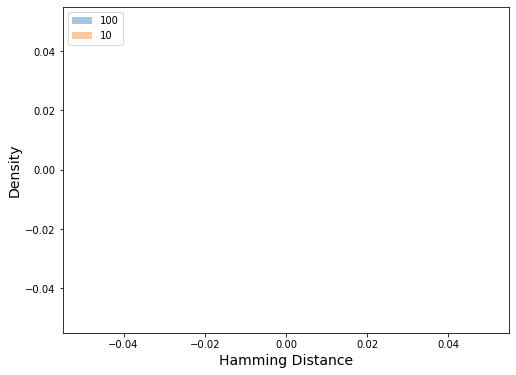

In [48]:
plt.figure(figsize=(8,6))

for topK in topKs:
    min_edit_dists = []
    for gen_seq in ddG_df.iloc[:topK]['MT_seq']:
        min_edit_dist = 99
        for train_seq in gen_train_df['MT_seq']:
            h_dist = hamming_dist(train_seq, gen_seq)
            if h_dist < min_edit_dist:
                min_edit_dist = h_dist

        min_edit_dists.append(min_edit_dist)

    topKs_min_edit_dists[topK] = min_edit_dists
    min_edit_mean = np.mean(min_edit_dists)
    min_edit_std = np.std(min_edit_dists)
    
    
    min_edit_min = np.min(min_edit_dists)
    min_edit_max = np.max(min_edit_dists)
    
    print("topK: ", topK)

    print("min_edit_min: ", min_edit_min)
    print("min_edit_max: ", min_edit_max)

    print("min_edit_mean: ", min_edit_mean)
    print("min_edit_std: ", min_edit_std)
    print("len(min_edit_dists): ", len(min_edit_dists))
    print("-----------")

    plt.hist(min_edit_dists, density=True, label=topK, bins=[i for i in range(12)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

# plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
# plt.title("Top 5% Generator")
plt.legend(loc='upper left')

In [49]:

# plt.figure(figsize=(8,6))
# plt.hist(min_edit_dists, density=True, label='generated', bins=[i for i in range(46)], alpha=0.4)
# # plt.xlabel("Hamming Distance", size=14)
# # plt.ylabel("Count", size=14)
# # plt.title("Hamming Distance from WT seq")

# plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Density", size=14)
# plt.title("Top 5% Generator")
# plt.legend(loc='upper left')